

# Projeto de Aprendizado de Máquina Aplicado à Robótica
## Equipe: 
- Bruno de Oliveira Pinheiro Júnior (bopj)
- Daniel Victor da Costa Carneiro Salvador (dvccs)
- Estela de Andrade Joffily (eaj2)

> --Esta célula pode ser apagada depois, é apenas para consultar o enunciado--

Item 1. Escolha uma base de dados (por exemplo do repositório UCI) de um problema de classificação ou regressão. Apresente o problema de forma suscinta, com suas variáveis
preditoras e alvo.

Item 2. Aplique o algoritmo de árvores de decisão e inspecione o conhecimento adquirido. Vc pode por exemplo selecionar a partir da árvore construída, regras com boa cobertura e confiança e discuti-las.

Item 3. Realize experimentos com algoritmos diversos e selecione o melhor algoritmo com base em uma métrica de avaliação de interesse. Justifique a escolha da métrica. Dependendo do algoritmo, faça experimentos com variação de parâmetros (e.g., valor do parâmetro k, do algoritmo kNN).

Item 4. Escolha um ou mais algoritmos de classificação (por exemplo, IBk) e use técnicas de seleção de atributos para identificar as variáveis consideradas mais relevantes para o problema de classificação escolhido. Analise o impacto da seleção de atributos, avaliando o algoritmo escolhido usando (a) todos os atributos do problema, ou seja, sem seleção (b) e apenas usando os atributos selecionados.

Item 5. Selecione o melhor modelo encontrado no item anterior e aplique pelo menos duas técnicas de interpretabilidade, como:

* Feature importante: discuta que características foram mais importantes para o modelo;

* Global surrogate: apresente o modelo interpretável gerado e discuta os insights observados com o modelo;  

* Local surrogate: apresente pelo menos dois exemplos a serem explicados e gere as explicações com o LIME;

* PDP: faça pelos menos três gráficos PDP, variando os atributos analisados e discuta os resultados; ou outras técnicas de interesse.

Discuta os insights e conclusões sobre a aplicação das técnicas de interpretabilidade aplicadas.

In [52]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier, plot_tree
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_recall_fscore_support

In [27]:
data = pd.read_csv('star_classification.csv')
data.head()

,obj_ID,alpha,delta,u,g,r,i,z,run_ID,rerun_ID,cam_col,field_ID,spec_obj_ID,class,redshift,plate,MJD,fiber_ID
0,1.237661e+18,135.689107,32.494632,23.87882,22.27530,20.39501,19.16573,18.79371,3606,301,2,79,6.543777e+18,GALAXY,0.634794,5812,56354,171
1,1.237665e+18,144.826101,31.274185,24.77759,22.83188,22.58444,21.16812,21.61427,4518,301,5,119,1.176014e+19,GALAXY,0.779136,10445,58158,427
2,1.237661e+18,142.188790,35.582444,25.26307,22.66389,20.60976,19.34857,18.94827,3606,301,2,120,5.152200e+18,GALAXY,0.644195,4576,55592,299
3,1.237663e+18,338.741038,-0.402828,22.13682,23.77656,21.61162,20.50454,19.25010,4192,301,3,214,1.030107e+19,GALAXY,0.932346,9149,58039,775
4,1.237680e+18,345.282593,21.183866,19.43718,17.58028,16.49747,15.97711,15.54461,8102,301,3,137,6.891865e+18,GALAXY,0.116123,6121,56187,842


In [28]:
id_columns = ['obj_ID', 'run_ID', 'rerun_ID', 'cam_col',
              'field_ID', 'spec_obj_ID', 'plate', 'MJD',
              'fiber_ID']

df = data.drop(columns=id_columns, axis=1)

X = df.drop(columns=['class'], axis=1)
y = df['class']

X.shape, y.shape

((100000, 8), (100000,))

In [29]:
df['class'].value_counts(normalize=True)

class
GALAXY    0.59445
STAR      0.21594
QSO       0.18961
Name: proportion, dtype: float64

### Apresentação do *dataset*

O [Stellar Classification Dataset - SDSS17](https://www.kaggle.com/datasets/fedesoriano/stellar-classification-dataset-sdss17?resource=download) é uma base de dados que classifica objetos estelares com base em suas características espectrais. Esse *dataset* contém 100.000 instâncias classificadas dentre estrelas, galáxias e quasares, provenientes de observações

### Aplicando árvore de decisão

In [30]:
def decision_tree_classifier_evaluate_depth(
        x_y_dataframe: tuple,
        min_depth: int,
        max_depth: int,
        min_samples_leaf: int = 1,
):
    """Function to evaluate the Decision Tree Classifier with different depths.

    Args:
        x_y_dataframe (tuple): A tuple containing the dataframe split into
            X and y, where y is a pandas.Series containing the labels.
        min_depth (int): The range minimum depth
        max_depth (int): The range maximum depth
        min_samples_leaf (int, optional): Defaults to 1.
    """
    X, y = x_y_dataframe
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

    for i in range(min_depth, max_depth+1):
        model = DecisionTreeClassifier(
            criterion='entropy',
            max_depth=i,
            random_state=42,
            min_samples_leaf=min_samples_leaf,
        )

        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)

        acc = accuracy_score(y_test, y_pred)
        matrix = confusion_matrix(y_test, y_pred, normalize='true')
        precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

        report = (f'Tree Max Depth: {i}\n'
                  f'Accuracy: {acc:.2f}\n'
                  f'Precision: {[round(x,2) for x in precision]}\n'
                  f'Recall: {[round(x,2) for x in recall]}\n'
                  f'F-Score: {[round(x,2) for x in fscore]}\n'
                  f'Support: {[round(x,2) for x in support]}\n')

        sns.heatmap(matrix, annot=True)
        plt.title(report)
        plt.show()
        print('----------------------------------------------------')

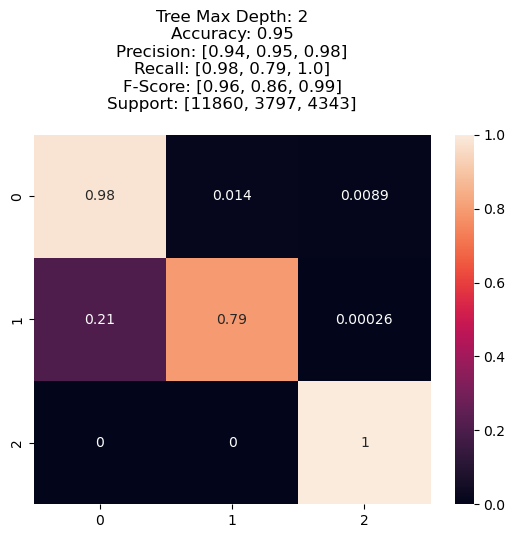

----------------------------------------------------


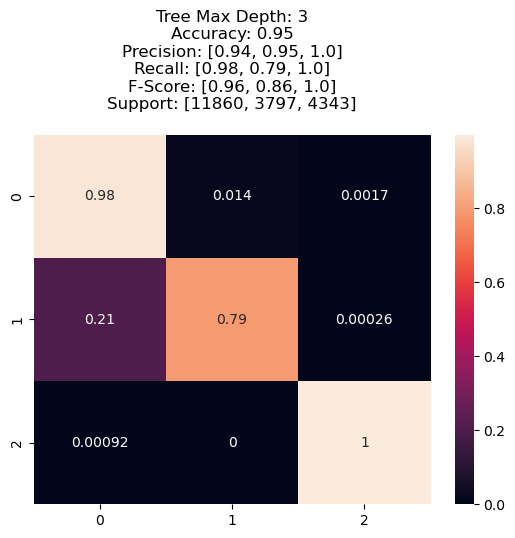

----------------------------------------------------


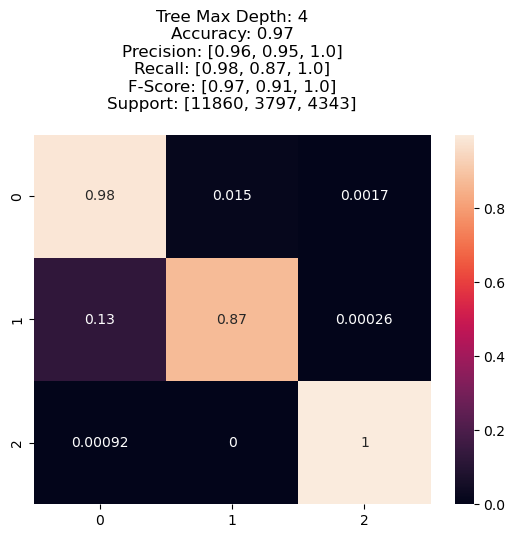

----------------------------------------------------


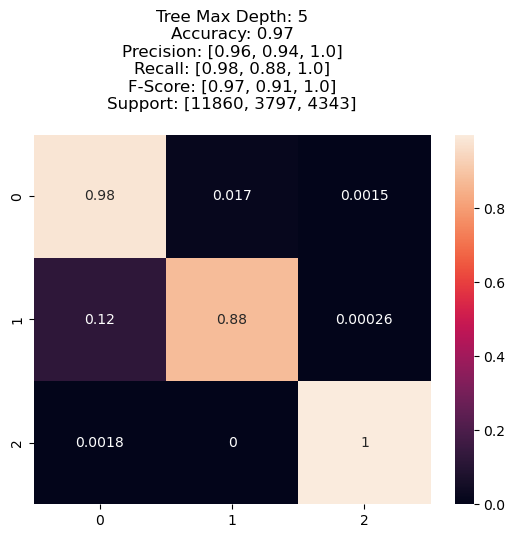

----------------------------------------------------


In [31]:
decision_tree_classifier_evaluate_depth(
    x_y_dataframe=(X, y),
    min_depth=2,
    max_depth=5,
)

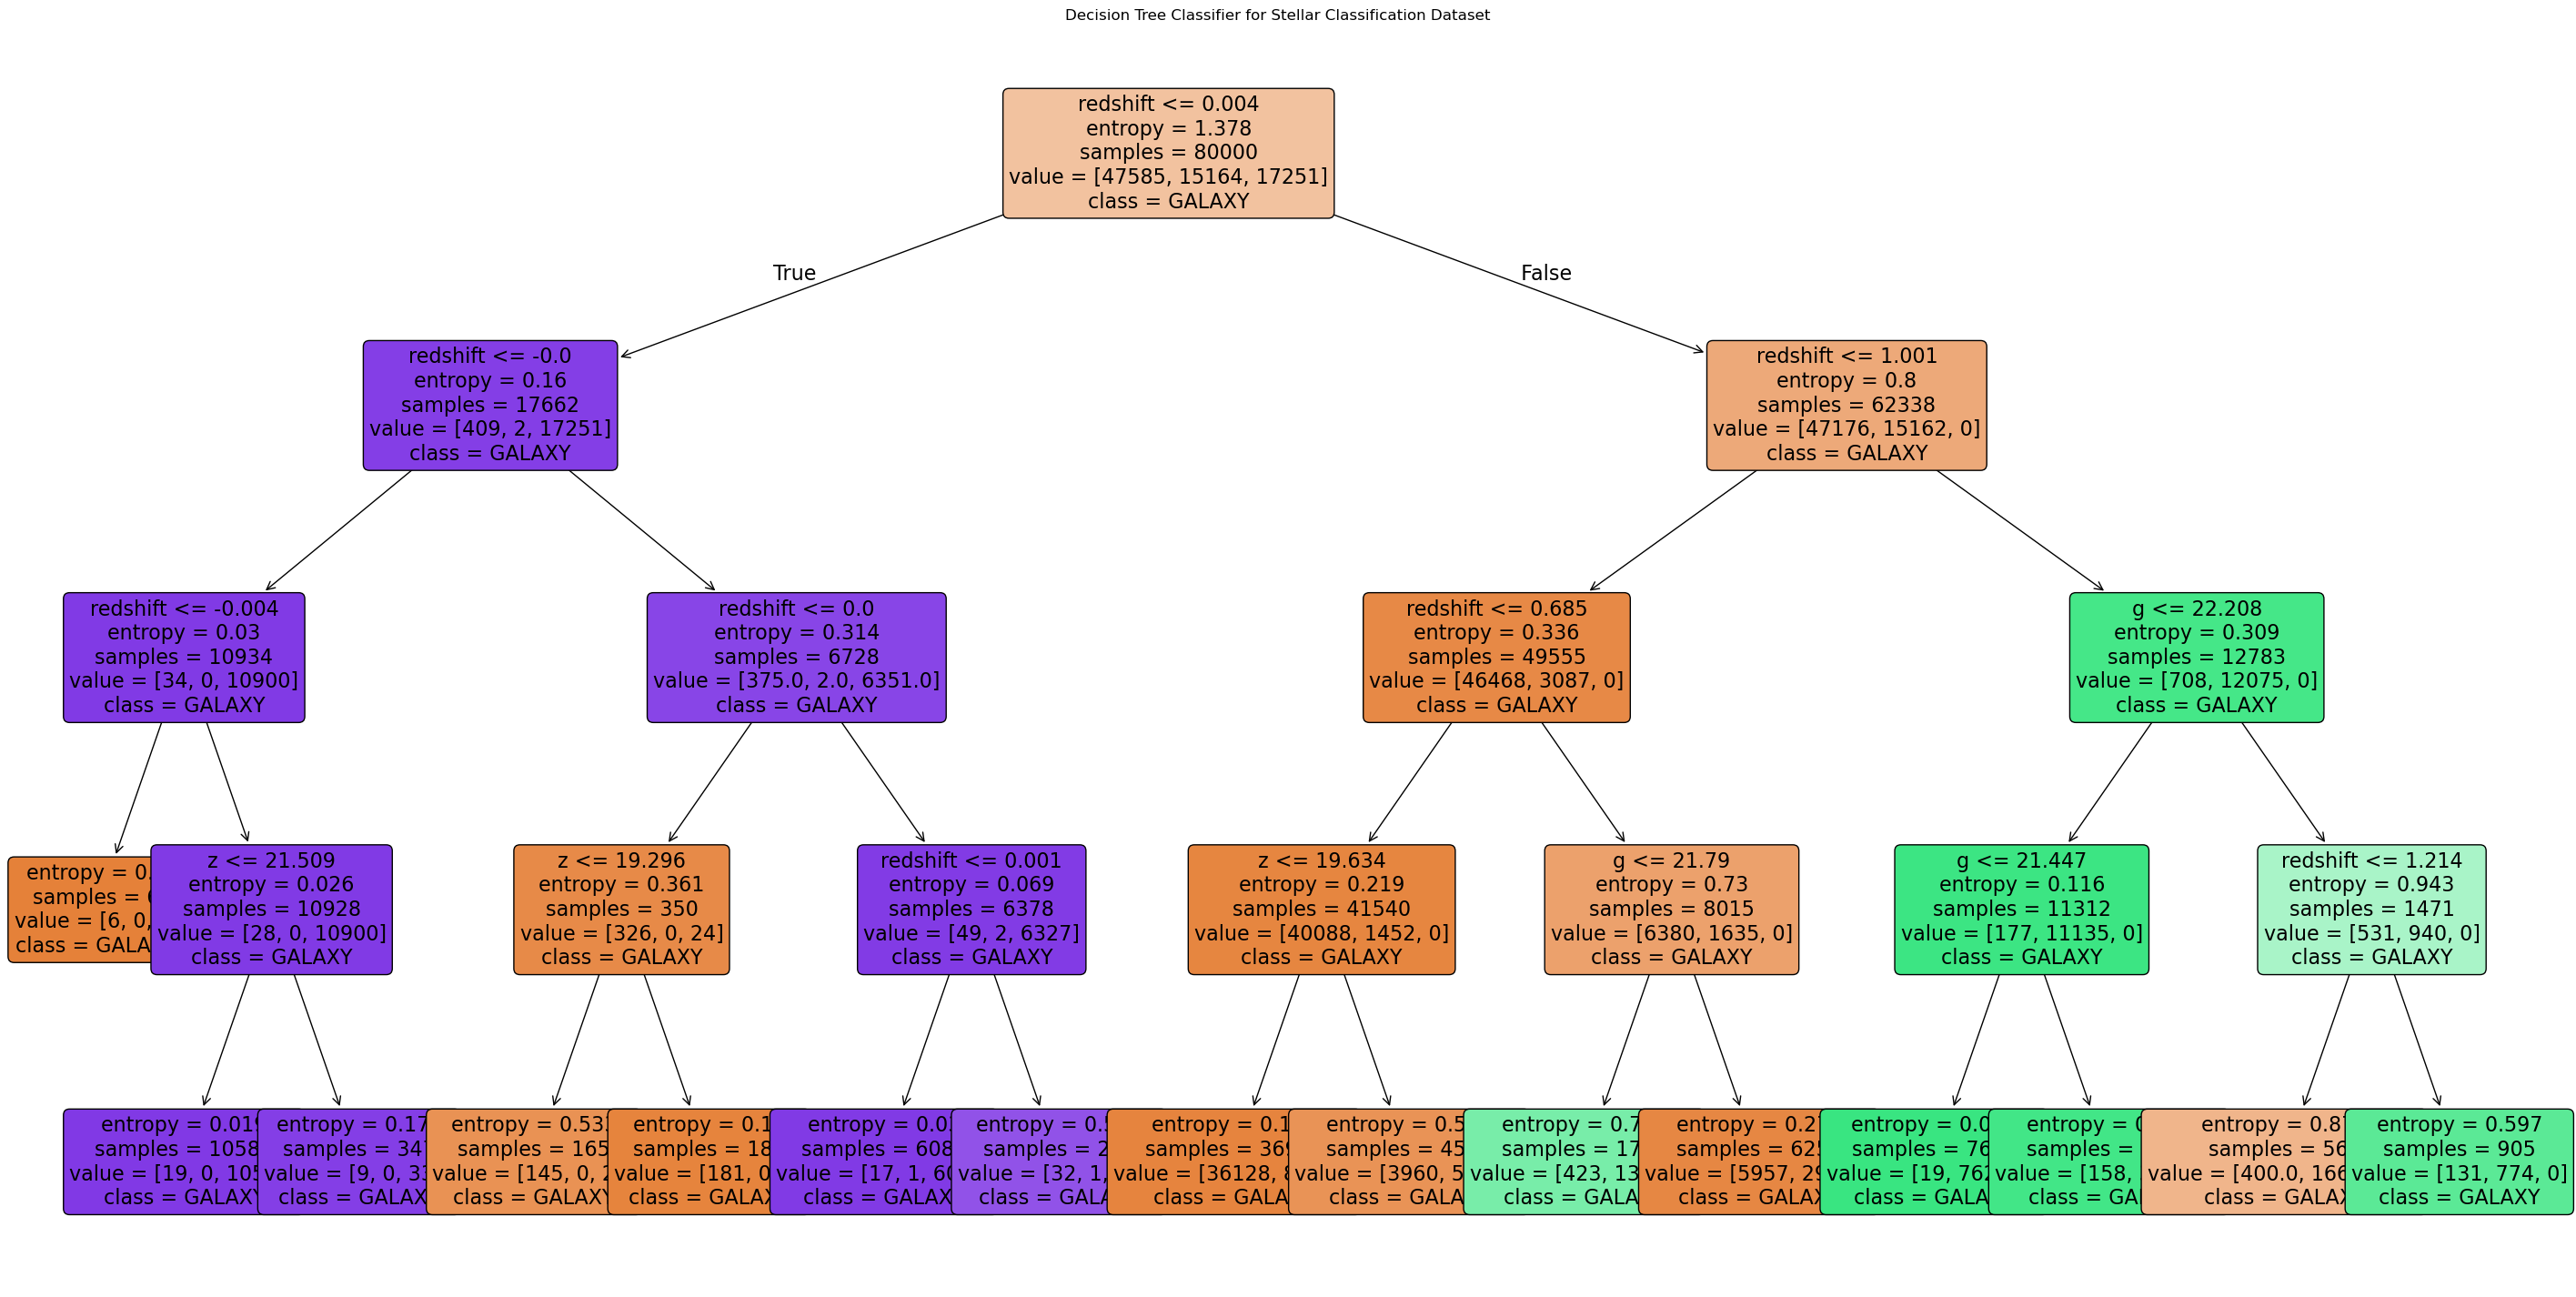

In [32]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = DecisionTreeClassifier(
    criterion='entropy',
    max_depth=4,
    min_samples_leaf=1,
)

model.fit(X_train, y_train)

plt.figure(figsize=(36, 18))
plot_tree(
    model,
    feature_names=X.columns.to_list(),
    class_names=y.values.tolist(),
    rounded=True,
    filled=True,
    fontsize=16,
)
plt.title('Decision Tree Classifier for Stellar Classification Dataset')
plt.show()

### Análise das regras

blah blah

### Treinando com -algoritmo 1 (exemplo: SVM)-

### Treinando com Categorical Naive Bayes

In [48]:
normalized_X=(X-X.min())/(X.max()-X.min())
X_train, X_test, y_train, y_test = train_test_split(normalized_X, y, test_size=0.2, random_state=42)
normalized_X.head()

,alpha,delta,u,g,r,i,z,redshift
0,0.376905,0.503802,0.999113,0.999070,0.535344,0.427665,0.998944,0.091831
1,0.402286,0.491812,0.999202,0.999126,0.646203,0.515986,0.999225,0.112389
2,0.394960,0.534139,0.999251,0.999109,0.546218,0.435729,0.998959,0.093170
3,0.940947,0.180600,0.998939,0.999220,0.596946,0.486717,0.998990,0.134210
4,0.959118,0.392679,0.998670,0.998602,0.337999,0.287021,0.998620,0.017959


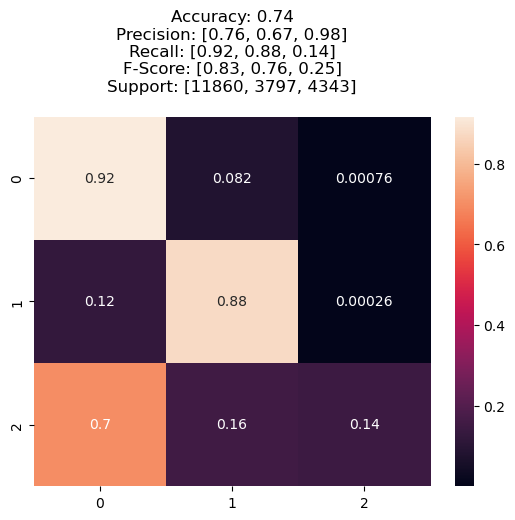

In [55]:
naive_bayes = GaussianNB()
naive_bayes.fit(X_train, y_train)

y_pred = naive_bayes.predict(X_test)
acc = accuracy_score(y_test, y_pred)
matrix = confusion_matrix(y_test, y_pred, normalize='true')
precision, recall, fscore, support = precision_recall_fscore_support(y_test, y_pred)

report = (  f'Accuracy: {acc:.2f}\n'
            f'Precision: {[round(x,2) for x in precision]}\n'
            f'Recall: {[round(x,2) for x in recall]}\n'
            f'F-Score: {[round(x,2) for x in fscore]}\n'
            f'Support: {[round(x,2) for x in support]}\n')

sns.heatmap(matrix, annot=True)
plt.title(report)
plt.show()


### Treinando com -algoritmo 3-